# Research Experiments on the effect of parent Selection on Generalization for symbolic Regression in GP

## Epsilon Lexicase Selection

* Masterseminar: SoSe 2022
* JGU Mainz
* FB 03 Recht-und Wirtschaftswissenschaften
* Lehrstuhl für Wirtschaftsinformatik und BWL

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import operator
from deap import gp, tools, creator, base, algorithms
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Callable
import math
from random import randint


## Energy efficiency Data Set

Source: https://archive.ics.uci.edu/ml/datasets/energy+efficiency

In [2]:
# (re-)download file to ./data

# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx -P ./data

In [3]:
D_PATH = "data/ENB2012_data.xlsx"

# TODO: research optimal splitsize!
TRAINING_D_SPLITSIZE = 0.5

def get_dataSets(datapath: str, train_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Read (excel) dataset at <datapath> and return two randomly split DFs for training/testing"""
    df = pd.read_excel(datapath)
    return train_test_split(df, train_size=train_size, test_size=(1-train_size))    

trainDF, testDF = get_dataSets(D_PATH, TRAINING_D_SPLITSIZE)

In [4]:
trainDF.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
661,0.66,759.5,318.5,220.5,3.5,3,0.40,3,15.18,17.63
392,0.86,588.0,294.0,147.0,7.0,2,0.25,3,28.40,33.52
93,0.62,808.5,367.5,220.5,3.5,3,0.10,1,12.97,14.50
575,0.62,808.5,367.5,220.5,3.5,5,0.40,1,17.14,17.20
81,0.69,735.0,294.0,220.5,3.5,3,0.10,1,11.13,14.61


In [5]:
trainDF.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,0.763620,671.963542,321.052083,175.455729,5.277344,3.453125,0.230990,2.888021,22.406995,24.563724
std,0.105175,87.703542,46.198585,45.620919,1.752069,1.068363,0.130286,1.553388,10.043404,9.419898
min,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.010000,10.940000
25%,0.690000,612.500000,294.000000,122.500000,3.500000,3.000000,0.100000,2.000000,12.945000,15.485000
50%,0.760000,661.500000,318.500000,147.000000,7.000000,3.000000,0.250000,3.000000,19.915000,24.610000
75%,0.820000,735.000000,343.000000,220.500000,7.000000,4.000000,0.400000,4.000000,31.660000,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,42.770000,47.010000


## Data Visualization

In [6]:
from matplotlib import pyplot as plt
import networkx as nx
import pygraphviz as pgv

%matplotlib inline

def plot_exprTree(expr_tree, title:str) -> None:
    """plots an expression tree"""
    nodes, edges, labels = gp.graph(expr_tree)

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="dot")

    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)

    plt.title(title)
    plt.show()

## GP System Setup

### Primitive set

In [7]:
UVS = {
    "ARG0" : "X1",
    "ARG1" : "X2",
    "ARG2" : "X3",
    "ARG3" : "X4",
    "ARG4" : "X5",
    "ARG5" : "X6",
    "ARG6" : "X7",
    "ARG7" : "X8",
}

# register the Primitive Set
pset = gp.PrimitiveSet("MAIN", arity=len(UVS))

# rename ARGS to match the dataset
for arg, des in UVS.items():
    pset.renameArguments(arg=des)


In [8]:
# adding functions

def saveDiv(lhs, rhs) -> float:
    """
    GP-save implementation of Division
    [@poli08:fieldguide, p.22]
    """
    if rhs == 0:
        return 1
    return lhs / rhs


operators = (
    (operator.add, 2),
    (operator.sub, 2),
    (operator.mul, 2),
    (saveDiv, 2),
    (math.sin, 1),
    (math.cos, 1),
    # FIXME: (math.exp, 1),
    # FIXME: (math.log, 1),
    (operator.neg, 1)
)

for (func, arity) in operators:
    pset.addPrimitive(func, arity)

pset.addEphemeralConstant("rand1", lambda: randint(-1,1))

### Custom Types

In [9]:
# min fitness object

# objective: minimize MAD for y1

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))


In [10]:
# individuals program
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

## Algorithmic specifications

In [11]:
# TODO: research alternatives

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [12]:
# fitness function for all fitness case:
def evaluate_df_y1_symReg (individual:creator.Individual, df:pd.core.frame.DataFrame) -> tuple[float]:
    """
    Evaluates an individual program for all fitness cases (=rows of pd.dataframe) inside the dataframe, computes and returns the mean absolute error for prediction and outcome for y1 and model prediction
    """
    # Transform the tree expression in a callable function
    compiled_individual = toolbox.compile(expr=individual)

    def evaluate_single_case_y1_symReg(func:Callable, case:pd.core.series.Series) -> float:
        """
        Evaluates an individual, compiled program for a single fitness case (=row of pd.dataframe), computes and returns the absolute error for prediction and outcome for y1 and model prediction
        """
        # compute individual with case variables
        y1_prediction = func(*case[0:8:].values)

        # optimal value:
        y1_value = case[8:9:].values[0]

        # compute absolute difference and return
        abs_error = abs(y1_prediction - y1_value)
        return (abs_error)
    
    n = len(df)
    abs_error_aggregate = 0.0

    # iterate through all fitness cases and aggregate absolute errors
    for _, fitness_case in df.iterrows():
        abs_error_aggregate += evaluate_single_case_y1_symReg(func=compiled_individual, case=fitness_case)
    
    # compute and return MAE
    mean_absolute_error = abs_error_aggregate / n
    return (mean_absolute_error, )


In [13]:
# GP system setup

toolbox.register("evaluate", evaluate_df_y1_symReg, df=trainDF)

# registration:
toolbox.register("select", tools.selAutomaticEpsilonLexicase)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# decoration:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

## Statistics

In [14]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [18]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min    	nevals	std    	avg    	gen	max	min	nevals	std    
0  	300   	3370.17	0  	551898	6.99196	300   	34933.2	3.43333	0  	7  	2  	300   	1.42556
1  	162   	56.2195	1  	5113.21	6.99196	162   	372.94 	3.07333	1  	9  	1  	162   	0.669295
2  	170   	83.5211	2  	12131  	6.99196	170   	725.223	3.12667	2  	9  	1  	170   	0.814835
3  	169   	95.2569	3  	15357.5	6.99196	169   	923.763	3.1    	3  	9  	1  	169   	0.675771
4  	183   	390.236	4  	105181 	6.99196	183   	6064.39	3.13333	4  	8  	1  	183   	0.689605
5  	164   	1454.26	5  	420344 	6.99196	164   	24231.5	3.08   	5  	9  	1  	164   	0.616658
6  	159   	46.697 	6  	3393.75	6.99196	159   	296.092	3.18   	6  	9  	1  	159   	0.909725
7  	174   	29.5881	7  	1130.12	6.99196	174   	130.364	3.12333	7  	7  	

mul(add(ARG5, ARG4), saveDiv(saveDiv(ARG2, -1), sub(mul(saveDiv(mul(ARG4, ARG6), ARG2), mul(ARG1, ARG4)), ARG3)))


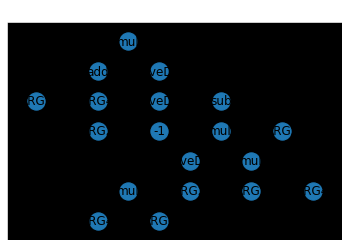

In [19]:

for elite in hof:
    winner = elite
    print (elite)
    plot_exprTree(elite, "Best Solution")

In [23]:
winner_func = gp.compile(winner, pset)

abs_err_agg = 0.0
n = len(testDF)

for _, case in testDF.iterrows():
    abs_err_agg += abs(winner_func(*case[0:8:].values) - case[8:9:].values[0])

MAE = abs_err_agg / n

print("Mean absolute error for unknown Dataset = ", MAE)

Mean absolute error for unknown Dataset =  4.833866349720192
